# - Clustering -

# Data Preparation

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

In [2]:
# Memasukkan Data
df = pd.read_csv('../input/customer-personality-analysis/marketing_campaign.csv', sep='\t')

In [3]:
# Menampilkan 5 Data teratas
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


# Data Cleaning

In [4]:
# Melihat Info dari setiap kolom
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [5]:
# Mengecek apakah terdapat nilai NULL atau tidak
df.isnull().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

In [6]:
# Total Baris dan Kolom sebelum di Hapus nilai NULL
print('Baris dan Kolom sebelum di hapus nilai NULL:', df.shape)

# Menghapus nilai NULL pada Baris
df.dropna(axis=0, inplace=True)

# Total Baris dan Kolom sesudah di Hapus nilai NULL
print('Baris dan Kolom sesudah di hapus nilai NULL:', df.shape)

Baris dan Kolom sebelum di hapus nilai NULL: (2240, 29)
Baris dan Kolom sesudah di hapus nilai NULL: (2216, 29)


# Data Transformation and Visualization

In [7]:
from datetime import date

In [8]:
# Transformasi Year_Birth menjadi Age
df['Age'] = date.today().year - df['Year_Birth']

# Memperbaiki format tipe Dt_Customer dari objek ke waktu
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])
# Mengecek apakah sudah menjadi tipe data waktu
print('Tipe kolom Dt_Customer:', df['Dt_Customer'].dtypes)

# Transformasi Dt_Customer menjadi Year_Enroll
df['Year_Enroll'] = pd.DatetimeIndex(df['Dt_Customer']).year
df['Enroll_Len'] = date.today().year - pd.DatetimeIndex(df['Dt_Customer']).year

# Mengubah tipe data Income float menjadi integer
df['Income'] = df['Income'].astype('int')

Tipe kolom Dt_Customer: datetime64[ns]


In [9]:
# Transformasi Kidhome dan Teenhome menjadi Children
df['Children'] = df['Kidhome']+df['Teenhome']

# Transformasi Mnt[Products] menjadi Spending (Pengeluaran)
df['Spending'] = np.sum(df.iloc[:, 9:14].values, axis=1)

# Mengganti Menyederhanakan kategori pada Pendidikan dan Status Pernikahan
df['Education'] = df['Education'].replace(dict.fromkeys(['Basic','2n Cycle'], 'Undergraduate')).replace(dict.fromkeys(['Graduation','Master','PhD'], 'Postgraduate'))
df['Marital_Status'] = df['Marital_Status'].replace(dict.fromkeys(['Divorced','Single','Absurd','Widow','YOLO'], 'Alone')).replace(dict.fromkeys(['Married','Together'], 'Couples'))

In [10]:
# Mengganti data lama dan Memilih data yang akan digunakan nanti
df = df[['ID','Age','Education','Marital_Status','Income','Children','Year_Enroll','Enroll_Len','Spending','MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds','Complain']]
# Menampilkan 5 Data teratas
df.head()

,ID,Age,Education,Marital_Status,Income,Children,Year_Enroll,Enroll_Len,Spending,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,Complain
0,5524,65,Postgraduate,Alone,58138,0,2012,10,1529,635,88,546,172,88,88,0
1,2174,68,Postgraduate,Alone,46344,2,2014,8,21,11,1,6,2,1,6,0
2,4141,57,Postgraduate,Couples,71613,0,2013,9,734,426,49,127,111,21,42,0
3,6182,38,Postgraduate,Couples,26646,1,2014,8,48,11,4,20,10,3,5,0
4,5324,41,Postgraduate,Couples,58293,1,2014,8,407,173,43,118,46,27,15,0


In [11]:
# Deskripsi Data setelah Pembersihan
df.select_dtypes('int').describe()

,ID,Age,Income,Children,Year_Enroll,Enroll_Len,Spending,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,Complain
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,5588.353339,53.179603,52247.251354,0.947202,2013.028430,8.971570,563.110108,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,0.009477
std,3249.376275,11.985554,25173.076661,0.749062,0.685618,0.685618,577.183371,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,0.096907
min,0.000000,26.000000,1730.000000,0.000000,2012.000000,8.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2814.750000,45.000000,35303.000000,0.000000,2013.000000,9.000000,55.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,0.000000
50%,5458.500000,52.000000,51381.500000,1.000000,2013.000000,9.000000,342.500000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,0.000000
75%,8421.750000,63.000000,68522.000000,1.000000,2013.000000,9.000000,964.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,0.000000
max,11191.000000,129.000000,666666.000000,3.000000,2014.000000,10.000000,2491.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,1.000000


In [12]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import Image
import os
os.makedirs('./chart')

In [13]:
pip install -U kaleido

     |████████████████████████████████| 79.9 MB 113 kB/s            
Note: you may need to restart the kernel to use updated packages.


In [14]:
dirs_img = './chart/'

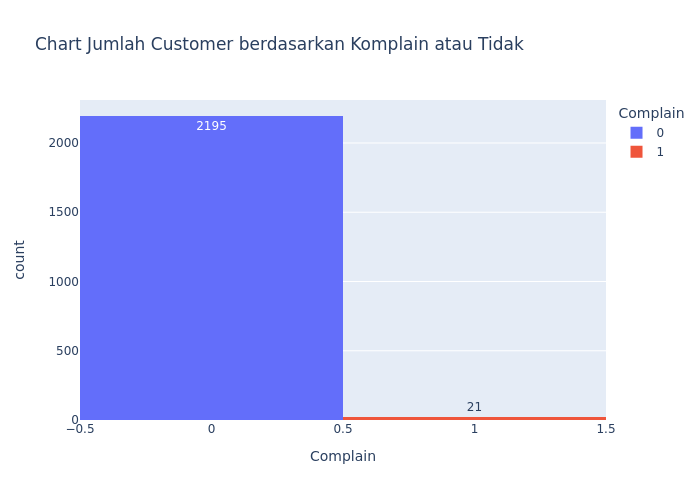

In [15]:
# Chart Jumlah Customer berdasarkan Komplain atau Tidak
fig_complain = px.histogram(df, x='Complain', y='ID', 
                            color='Complain', histfunc='count', text_auto='auto',
                            title='Chart Jumlah Customer berdasarkan Komplain atau Tidak')
fig_complain.write_image(dirs_img+'cpa_customer_by_complain.png')
Image(dirs_img+'cpa_customer_by_complain.png')

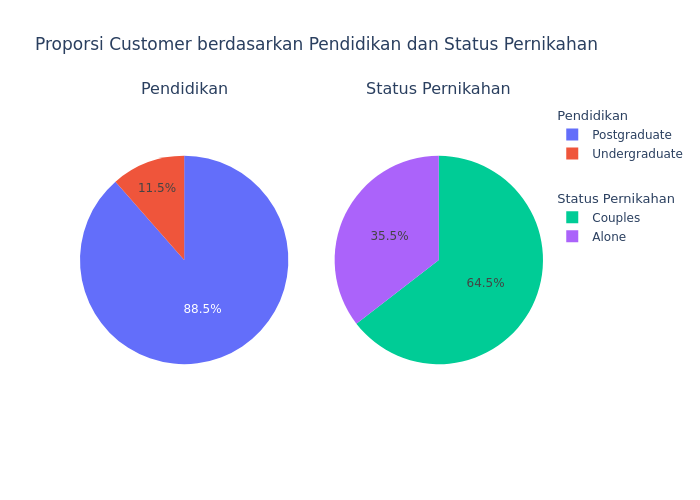

In [16]:
# Proporsi Customer berdasarkan Pendidikan dan Status Pernikahan
df_edu = df.groupby(by=['Education']).size().reset_index(name='counts')
df_marstat = df.groupby(by=['Marital_Status']).size().reset_index(name='counts')

fig_proportion = make_subplots(rows=1, cols=2, 
                               specs=[[{"type": "pie"}, {"type": "pie"}]], 
                               subplot_titles=('Pendidikan',  'Status Pernikahan'))

fig_proportion.add_trace(go.Pie(values=df_edu['counts'],
                                labels=df_edu['Education'],
                                name='Pendidikan',
                                legendgroup='1',
                                legendgrouptitle_text='Pendidikan'),
                                row=1, col=1)

fig_proportion.add_trace(go.Pie(values=df_marstat['counts'],
                                labels=df_marstat['Marital_Status'],
                                name='Status Pernikahan', 
                                legendgroup='2',
                                legendgrouptitle_text='Status Pernikahan'), 
                                row=1, col=2)

fig_proportion.update_layout(title_text='Proporsi Customer berdasarkan Pendidikan dan Status Pernikahan',
                             legend_tracegroupgap=25)
fig_proportion.write_image(dirs_img+'cpa_proporsion_customer.png')
Image(dirs_img+'cpa_proporsion_customer.png')

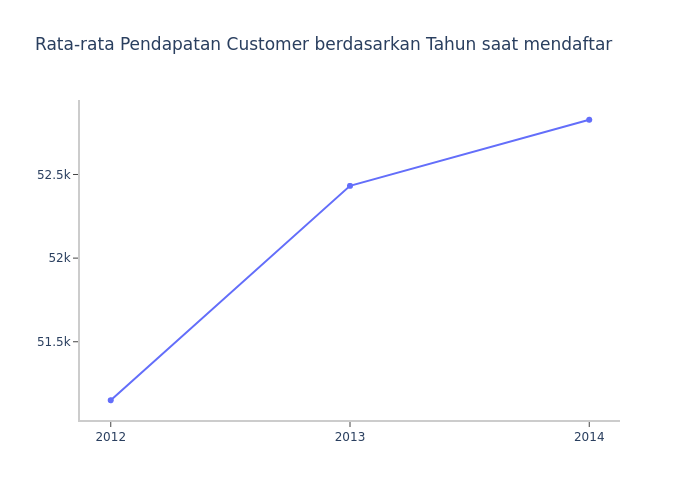

In [17]:
# Chart Rata-rata Pendapatan Customer berdasarkan Tahun saat mendaftar
df_mean_income = df.groupby(['Year_Enroll'])['Income'].mean().reset_index(name='Avg_Income')
fig_income = go.Figure()
fig_income.add_trace(go.Scatter(x=df_mean_income['Year_Enroll'], 
                                y=df_mean_income['Avg_Income'], 
                                mode='lines+markers'))
fig_income.update_layout(xaxis=dict(tickvals=df_mean_income['Year_Enroll'].values,
                                    showline=True, ticks='outside', linecolor='rgb(204, 204, 204)', linewidth=2,),
                         yaxis=dict(showline=True, ticks='outside', linecolor='rgb(204, 204, 204)', linewidth=2,),
                         title='Rata-rata Pendapatan Customer berdasarkan Tahun saat mendaftar',
                         plot_bgcolor='white')
fig_income.write_image(dirs_img+'cpa_avg_income_customer.png')
Image(dirs_img+'cpa_avg_income_customer.png')

In [18]:
from sklearn.preprocessing import LabelEncoder, RobustScaler, normalize

In [19]:
# Mengkodekan kolom kategori yang bertipe Object menjadi Numerik
le = LabelEncoder()

df['Education'] = le.fit_transform(df['Education'])
df['Marital_Status'] = le.fit_transform(df['Marital_Status'])

# Fitur Skala pada Income, Spending dan Education. kemudian di normalisasikan
rs = RobustScaler()
X_rs = rs.fit_transform(df[['Income','Spending','Education']])
X_norm = normalize(X_rs, norm='l2')

# Modelling

In [20]:
from sklearn.cluster import KMeans

Disini saya akan membuat klaster 3 dimensi dengan 4 Klaster:
1. **Tingkat 1** = Pendapatan dan pengeluaran rata-ratanya tinggi dengan jumlah lulusan pendidikan sarjana dan pascasarjana banyak
2. **Tingkat 2** = Pendapatan dan pengeluaran rata-ratanya rendah dengan jumlah lulusan pendidikan sarjana dan pascasarjana banyak
3. **Tingkat 3** = Pendapatan rata-ratanya sedang dan pengeluaran rata-ratanya rendah dengan jumlah lulusan pendidikan sarjana dan pascasarjana sedikit
4. **Tingkat 4** = Pendapatan dan pengeluaran rata-ratanya rendah dengan jumlah lulusan pendidikan sarjana dan pascasarjana sedikit

In [21]:
# Menjalankan pemodelan dengan jumlah klasternya 4
model = KMeans(n_clusters=4, random_state=5, max_iter=1000).fit(X_norm)
label = model.predict(X_norm)

# Memasukkan hasil label dari pemodelan dengan membuat kolom baru Cluster
df['Cluster'] = label
df['Cluster'] = df['Cluster'].replace({0:'Tingkat 1',1:'Tingkat 2',2:'Tingkat 3',3:'Tingkat 4'})

result_cluster = df[['Income','Spending','Education','Cluster']]
result_cluster.set_index('Cluster', inplace = True)

# Menampilkan Deskripsi data hasil cluster
result_cluster.groupby('Cluster').describe().transpose()

Cluster              Tingkat 1     Tingkat 2      Tingkat 3     Tingkat 4
Income    count     148.000000    856.000000    1015.000000    197.000000
          mean    58551.952703  33882.633178   70688.227586  32295.101523
          std     18097.652730   9822.042538   22386.653021  15424.287803
          min     47691.000000   1730.000000   43185.000000   7500.000000
          25%     51308.000000  27585.750000   61436.000000  20981.000000
          50%     54197.500000  35073.000000   69719.000000  27190.000000
          75%     59046.250000  41594.500000   78447.500000  45204.000000
          max    162397.000000  50501.000000  666666.000000  71488.000000
Spending  count     148.000000    856.000000    1015.000000    197.000000
          mean      162.479730    115.019860    1080.687685    144.416244
          std        93.796456    133.816260     455.604815    211.345928
          min         5.000000      4.000000      50.000000      8.000000
          25%        82.250000     33.000000     727.000000     31.000000
          50%       152.000000     57.500000    1024.000000     48.000000
          75%       254.000000    151.000000    1385.500000    154.000000
          max       341.000000   1729.000000    2491.000000   1110.000000
Education count     148.000000    856.000000    1015.000000    197.000000
          mean        0.000000      0.000000       0.056158      1.000000
          std         0.000000      0.000000       0.230339      0.000000
          min         0.000000      0.000000       0.000000      1.000000
          25%         0.000000      0.000000       0.000000      1.000000
          50%         0.000000      0.000000       0.000000      1.000000
          75%         0.000000      0.000000       0.000000      1.000000
          max         0.000000      0.000000       1.000000      1.000000

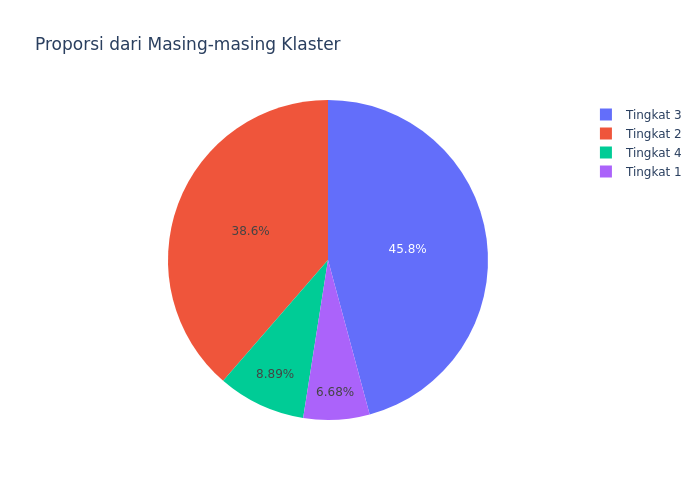

In [22]:
# Melihat terlebih dahulu proporsi dari masing-masing cluster
df_cluster = df.groupby(by=['Cluster']).size().reset_index(name='counts')
fig_cluster = px.pie(df_cluster, values='counts', names='Cluster', title='Proporsi dari Masing-masing Klaster')
fig_cluster.write_image(dirs_img+'cpa_proportion_of_cluster.png')
Image(dirs_img+'cpa_proportion_of_cluster.png')

In [23]:
# Pivot tabel
df.pivot_table(index='Cluster',aggfunc='mean')

,Age,Children,Complain,Education,Enroll_Len,ID,Income,Marital_Status,MntFishProducts,MntFruits,MntGoldProds,MntMeatProducts,MntSweetProducts,MntWines,Spending,Year_Enroll
Cluster,,,,,,,,,,,,,,,,
Tingkat 1,57.810811,1.405405,0.000000,0.000000,8.635135,5489.337838,58551.952703,0.662162,8.310811,6.216216,19.932432,35.898649,8.506757,103.547297,162.479730,2013.364865
Tingkat 2,51.106308,1.241822,0.011682,0.000000,8.939252,5567.382009,33882.633178,0.636682,8.579439,5.601636,20.586449,33.332944,5.448598,62.057243,115.019860,2013.060748
Tingkat 3,55.353695,0.626601,0.007882,0.056158,9.032512,5620.759606,70688.227586,0.641379,69.459113,49.062069,69.801970,324.660099,50.249261,587.257143,1080.687685,2012.967488
Tingkat 4,47.507614,0.974619,0.015228,1.000000,9.050761,5586.898477,32295.101523,0.690355,21.979695,14.680203,30.487310,33.944162,15.076142,58.736041,144.416244,2012.949239


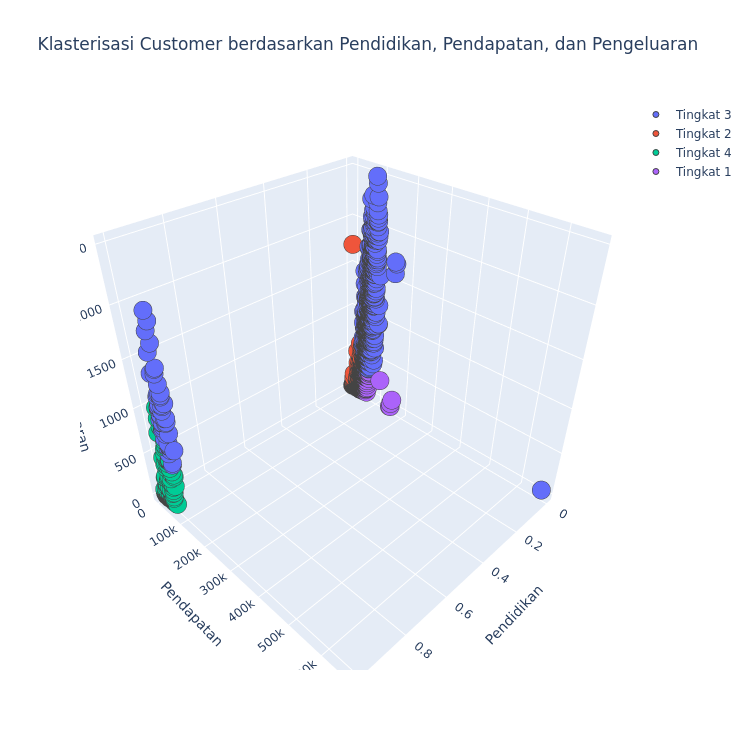

In [24]:
# Memplotkan hasil dari cluster yang sudah didapatkan dari pemodelan berdasarkan Income, Spending, dan Education
plot_model = go.Figure()
for cluster in list(df.Cluster.unique()):
    plot_model.add_trace(go.Scatter3d(x=df[df.Cluster == cluster]['Education'],
                                      y=df[df.Cluster == cluster]['Income'],
                                      z=df[df.Cluster == cluster]['Spending'],                        
                                      mode='markers', marker_size=6, marker_line_width=1,
                                      name=str(cluster)))

plot_model.update_traces(hovertemplate='Pendidikan: %{x} <br>Pendapatan: %{y} <br>Pengeluaran: %{z}')
plot_model.update_layout(width=750, height=750, autosize=True, showlegend=True,
                             scene=dict(xaxis=dict(title='Pendidikan'),
                                        yaxis=dict(title='Pendapatan'),
                                        zaxis=dict(title='Pengeluaran')),
                             title='Klasterisasi Customer berdasarkan Pendidikan, Pendapatan, dan Pengeluaran')
plot_model.write_image(dirs_img+'cpa_plot_model.png')
Image(dirs_img+'cpa_plot_model.png')

In [25]:
df

,ID,Age,Education,Marital_Status,Income,Children,Year_Enroll,Enroll_Len,Spending,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,Complain,Cluster
0,5524,65,0,0,58138,0,2012,10,1529,635,88,546,172,88,88,0,Tingkat 3
1,2174,68,0,0,46344,2,2014,8,21,11,1,6,2,1,6,0,Tingkat 2
2,4141,57,0,1,71613,0,2013,9,734,426,49,127,111,21,42,0,Tingkat 3
3,6182,38,0,1,26646,1,2014,8,48,11,4,20,10,3,5,0,Tingkat 2
4,5324,41,0,1,58293,1,2014,8,407,173,43,118,46,27,15,0,Tingkat 3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,55,0,1,61223,1,2013,9,1094,709,43,182,42,118,247,0,Tingkat 3
2236,4001,76,0,1,64014,3,2014,8,436,406,0,30,0,0,8,0,Tingkat 3
2237,7270,41,0,0,56981,0,2014,8,1217,908,48,217,32,12,24,0,Tingkat 3
2238,8235,66,0,1,69245,1,2014,8,782,428,30,214,80,30,61,0,Tingkat 3


# Conclusion
Berdasarkan dari hasil output diatas dapat disimpulkan bahwa:
1. Berdasarkan output ke-21 dan 22. Dari 2216 Customer yang telah dikelompokkan menjadi 4 Cluster, terlihat bahwa proporsi Cluster Tingkat 1 yang paling banyak Customernya dibandingkan Cluster lainnya.
2. Rata-rata Pendapatan dan Pengeluaran Customer yang didapat pada masing-masing Cluster yakni,
    * Tingkat 1 sebesar 70688.23 USD dan 1080.69 USD
    * Tingkat 2 sebesar 33882.63 USD dan 115.02 USD
    * Tingkat 3 sebesar 58551.95 USD dan 162.48 USD
    * Tingkat 4 sebesar 32295.1 USD dan 144.42 USD
3. Berdasarkan output ke-23. Pada Cluster pendapatan dan pengeluaran rata-ratanya tinggi dengan jumlah lulusan pendidikan sarjana dan pascasarjana banyak, lebih banyak uang yang mereka harus keluarkan untuk membeli produk seperti Wine, Fruit, Meat, Fish, Sweet, dan Gold.
4. Output ke-24 merupakan Grafik Penyebaran yang sudah sesuai di Klasterisasikan berdasarkan Pendidikan, Pendapatan, dan Pengeluaran.